In [1]:
import pandas as pd
import numpy as np
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
from pmdarima import auto_arima

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Run the stored data from the Data_Preparation.ipynb
%run ..//Data_Preparation.ipynb

Data types in 'indu' dataframe:
Time       datetime64[ns]
indu_Q1           float64
indu_Q2           float64
indu_Q3           float64
indu_Q4           float64
indu_Q5           float64
indu_Q7           float64
dtype: object

Data types in 'cons' dataframe:
Time        datetime64[ns]
cons_Q1            float64
cons_Q2            float64
cons_Q3            float64
cons_Q4            float64
cons_Q5            float64
cons_Q6            float64
cons_Q7            float64
cons_Q8            float64
cons_Q9            float64
cons_Q10           float64
cons_Q11           float64
cons_Q12           float64
dtype: object

Data types in 'gdp' dataframe:
Time     datetime64[ns]
Value           float64
dtype: object
indu_Q1           float64
indu_Q2           float64
indu_Q3           float64
indu_Q4           float64
indu_Q5           float64
indu_Q7           float64
Time       datetime64[ns]
dtype: object
cons_Q1            float64
cons_Q2            float64
cons_Q3            float64
con

In [3]:
#Using the period 1990-2020 for training and 2021-2023 for testing
indu_train = indu[(indu['Time'] >= '1990-01-01') & (indu['Time'] < '2020-01-01')]
cons_train = cons[(cons['Time'] >= '1990-01-01') & (cons['Time'] < '2020-01-01')]
gdp_train = gdp[(gdp['Time'] >= '1990-01-01') & (gdp['Time'] < '2020-01-01')]

indu_test = indu[(indu['Time'] >= '2020-01-01') & (indu['Time'] < '2024-01-01')]
cons_test = cons[(cons['Time'] >= '2020-01-01') & (cons['Time'] < '2024-01-01')]
gdp_test = gdp[(gdp['Time'] >= '2020-01-01') & (gdp['Time'] < '2024-01-01')]

#Printing the length of the training and testing data
print("indu lenght: ", len(indu_train), " cons lenght: ", len(cons_train)," gdp lenght: ", len(gdp_train))
print("indu lenght: ", len(indu_test), " cons lenght: ", len(cons_test)," gdp lenght: ", len(gdp_test))

indu lenght:  120  cons lenght:  120  gdp lenght:  120
indu lenght:  16  cons lenght:  16  gdp lenght:  16


In [4]:
# Resetting the index
gdp_train.reset_index(drop=True, inplace=True)
indu_train.reset_index(drop=True, inplace=True)
cons_train.reset_index(drop=True, inplace=True)

# Combine the explanatory variables into a single DataFrame
exog_train = pd.concat([indu_train, cons_train], axis=1)
exog_test = pd.concat([indu_test, cons_test], axis=1)

# Remove the Time column
exog_train.drop('Time', axis=1, inplace=True)

# Initialize an empty list to store forecast values
forecast_values = []

i = 0
while i < len(indu_test):  # Continue looping until all observations are used
    print(f"Iteration {i}:")
    # Fit auto_arima function to the data
    arimax_model = auto_arima(gdp_train['Value'], exogenous=exog_train,
                              start_p=1, start_q=1,
                              max_p=3, max_q=3,
                              seasonal=False,
                              trace=False, error_action='ignore', suppress_warnings=True, stepwise=True)

    # Forecast the next value
    forecast = arimax_model.predict(n_periods=1, exogenous=exog_test.iloc[[i]])

    print("Forecast:", forecast)

    # Append the forecasted value to the list
    forecast_values.append(forecast.iloc[0])

    # Assign the last observation from the test set to the training set
    gdp_train.loc[len(gdp_train)] = gdp_test.iloc[i]
    indu_train.loc[len(indu_train)] = indu_test.iloc[i]
    cons_train.loc[len(cons_train)] = cons_test.iloc[i]

    i += 1  # Increment the counter

Iteration 0:
Forecast: 120    574.150304
dtype: float64
Iteration 1:
Forecast: 121    597.675295
dtype: float64
Iteration 2:
Forecast: 122    541.385388
dtype: float64
Iteration 3:
Forecast: 123    591.421535
dtype: float64
Iteration 4:
Forecast: 124    588.530271
dtype: float64
Iteration 5:
Forecast: 125    586.767836
dtype: float64
Iteration 6:
Forecast: 126    621.426276
dtype: float64
Iteration 7:
Forecast: 127    641.294582
dtype: float64
Iteration 8:
Forecast: 128    675.444278
dtype: float64
Iteration 9:
Forecast: 129    674.356843
dtype: float64
Iteration 10:
Forecast: 130    691.76633
dtype: float64
Iteration 11:
Forecast: 131    744.537884
dtype: float64
Iteration 12:
Forecast: 132    721.464575
dtype: float64
Iteration 13:
Forecast: 133    717.744544
dtype: float64
Iteration 14:
Forecast: 134    681.307987
dtype: float64
Iteration 15:
Forecast: 135    694.940001
dtype: float64


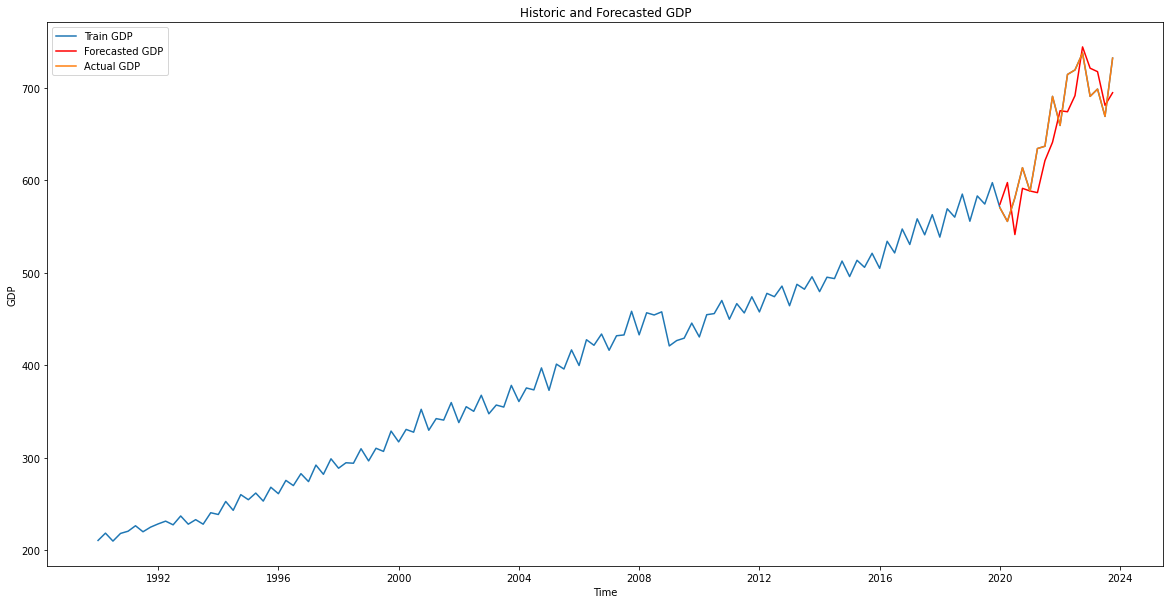

In [5]:
# Plotting historic GDP and forecasted GDP
plt.figure(figsize=(20,10))
plt.plot(gdp_train['Time'].to_numpy(), gdp_train['Value'].to_numpy(), label='Train GDP')
plt.plot(gdp_test['Time'].to_numpy(), forecast_values, color='red', label='Forecasted GDP')
plt.plot(gdp_test['Time'].to_numpy(), gdp_test['Value'].to_numpy(), label='Actual GDP')

# Set the title and labels
plt.title('Historic and Forecasted GDP')
plt.xlabel('Time')
plt.ylabel('GDP')

# Add a legend
plt.legend()

# Display the plot
plt.show()

In [6]:
#Comparing the forecasted values with the actual values trough RMSE and MAPE
# Calculate the RMSE
rmse_value = rmse(gdp_test['Value'], forecast_values)
#Calculate the MAPE
mape_value = mean_absolute_percentage_error(gdp_test['Value'], forecast_values) * 100 #Multiplying by 100 to get the percentage

# Print the RMSE
print("The RMSE is", rmse_value)
# Print the MAPE
print("The MAPE is", mape_value)

#The RMSE is 30. The forecasted values are close to the actual values.
#The MAPE is 3,9%.

The RMSE is 29.992965586795282
The MAPE is 3.924223979590787
